In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List
from tqdm import tqdm
from PIL import Image

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms, utils
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, auc, precision_recall_curve
import torch.nn.functional as F
from torchvision import models

from utils import *

## Load the data

In [2]:
# Define transform to reshape image to 256x256 and normalise to ImageNet standards
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std = [0.229, 0.224, 0.225]
        )
    ])

In [3]:
img_dir = "C:/Users/gatla/OneDrive/BSE/Thesis/labelled_dataset/all_frames"

# Define datasets for val/test
val_dataset = WarDataset(img_dir, 'data/val_labels.csv', transform=transform)
test_dataset = WarDataset(img_dir, 'data/test_labels.csv', transform=transform)

# Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Load the model

TO DO: Angelo to confirm optimal architecture and appropriate place to save the weights

In [4]:
# Define model architecture to load weights into
trained_model = torchvision.models.resnet50(weights=("pretrained", models.ResNet50_Weights.IMAGENET1K_V1))

num_ftrs = trained_model.fc.in_features

trained_model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 1)
)

# Load weights from optimal model
trained_model.load_state_dict(torch.load("C:/Users/gatla/Downloads/resnet50_TL-All.pth", map_location=lambda storage, loc: storage))

# Move the model to GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
trained_model.to(device)

c:\Users\gatla\anaconda3\envs\pytorch_image\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Test predictions

In [5]:
test_images, test_labels, test_probs = evaluate_model_with_images(trained_model, test_loader, device=device)
val_images, val_labels, val_probs = evaluate_model_with_images(trained_model, val_loader, device=device)

Evaluating: 100%|██████████| 49/49 [03:24<00:00,  4.17s/batch]


### ROC-AUC curve

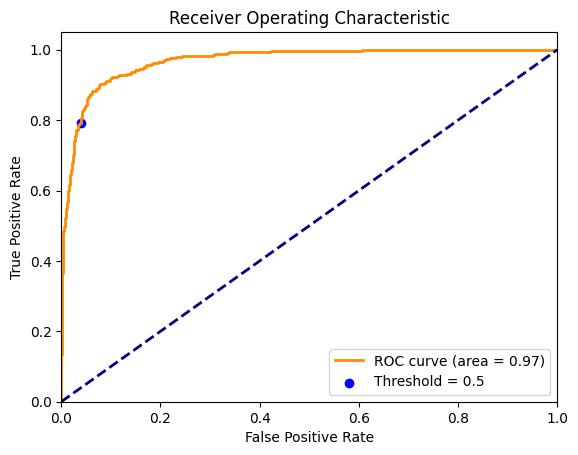

Threshold 0.5: FPR = 0.03884297520661157 TPR = 0.7911764705882353


In [6]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(val_labels, val_probs)

# Find the index of the threshold closest to 0.5
threshold_05_idx = np.argmin(np.abs(thresholds - 0.5))

# Compute ROC area
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[threshold_05_idx], tpr[threshold_05_idx], color='blue', label='Threshold = 0.5')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print('Threshold 0.5: FPR =', fpr[threshold_05_idx], 'TPR =', tpr[threshold_05_idx])

### Precision and Recall Curve

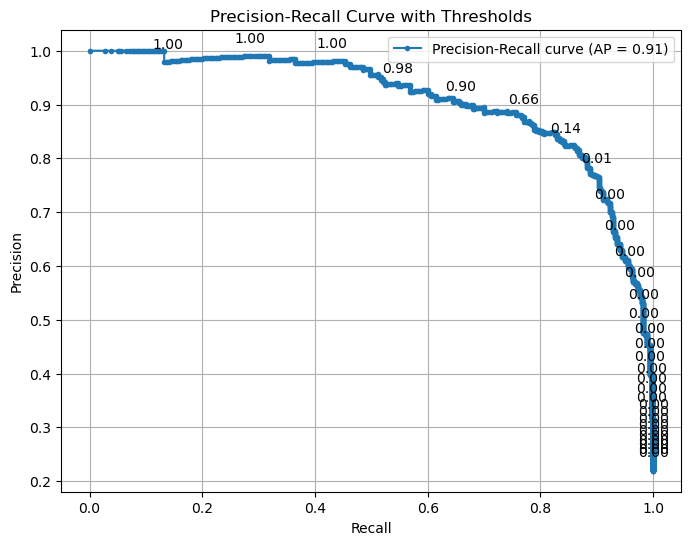

In [94]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# Compute precision-recall curve and average precision score
precision, recall, thresholds = precision_recall_curve(val_labels, val_probs)
average_precision = average_precision_score(val_labels, val_probs)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Precision-Recall curve (AP = {average_precision:.2f})')

# Plot points with thresholds
for i in range(len(thresholds)):
    if i % 50 == 0:  # Show every 50th threshold for clarity
        plt.annotate(f'{thresholds[i]:.2f}', (recall[i], precision[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Thresholds')
plt.legend()
plt.grid()
plt.show()


In [8]:
# Calculate the best threshold
best_threshold, best_f1 = find_best_threshold(val_labels, val_probs)
print(f"Best Threshold: {best_threshold}")
# Generate final predictions based on optimal threshold
test_preds = [1 if prob >= 0.5 else 0 for prob in test_probs]

Best Threshold: 0.1


Plotting the computed metrics

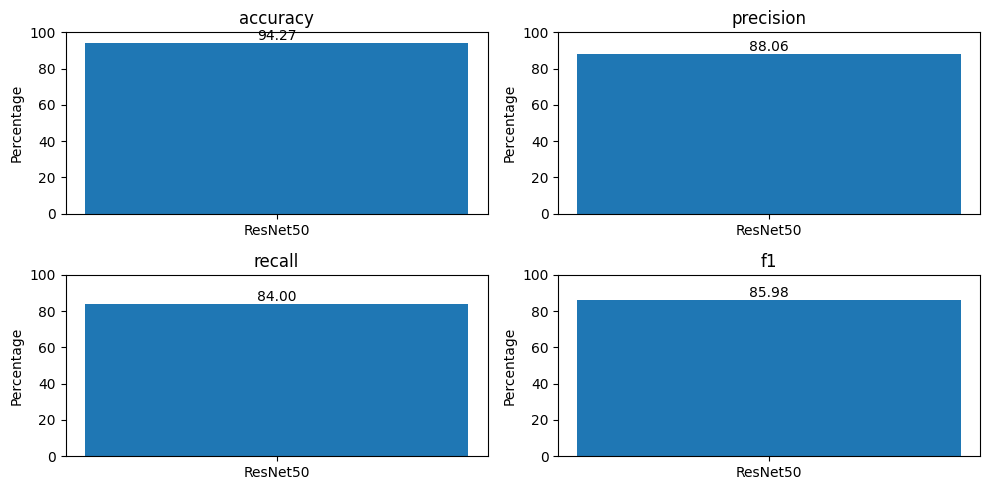

In [9]:
metrics = Metrics()
metrics.run(test_labels, test_preds, "ResNet50")
metrics.plot()

# Confusion Matrix

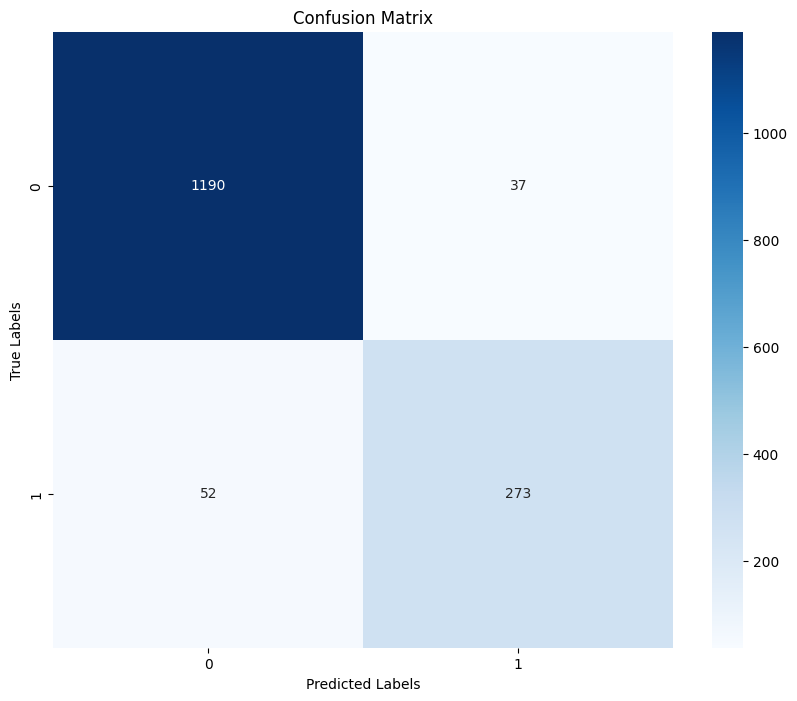

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Counfusion Matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Analysis of False Positives

Last plotted image index: 707


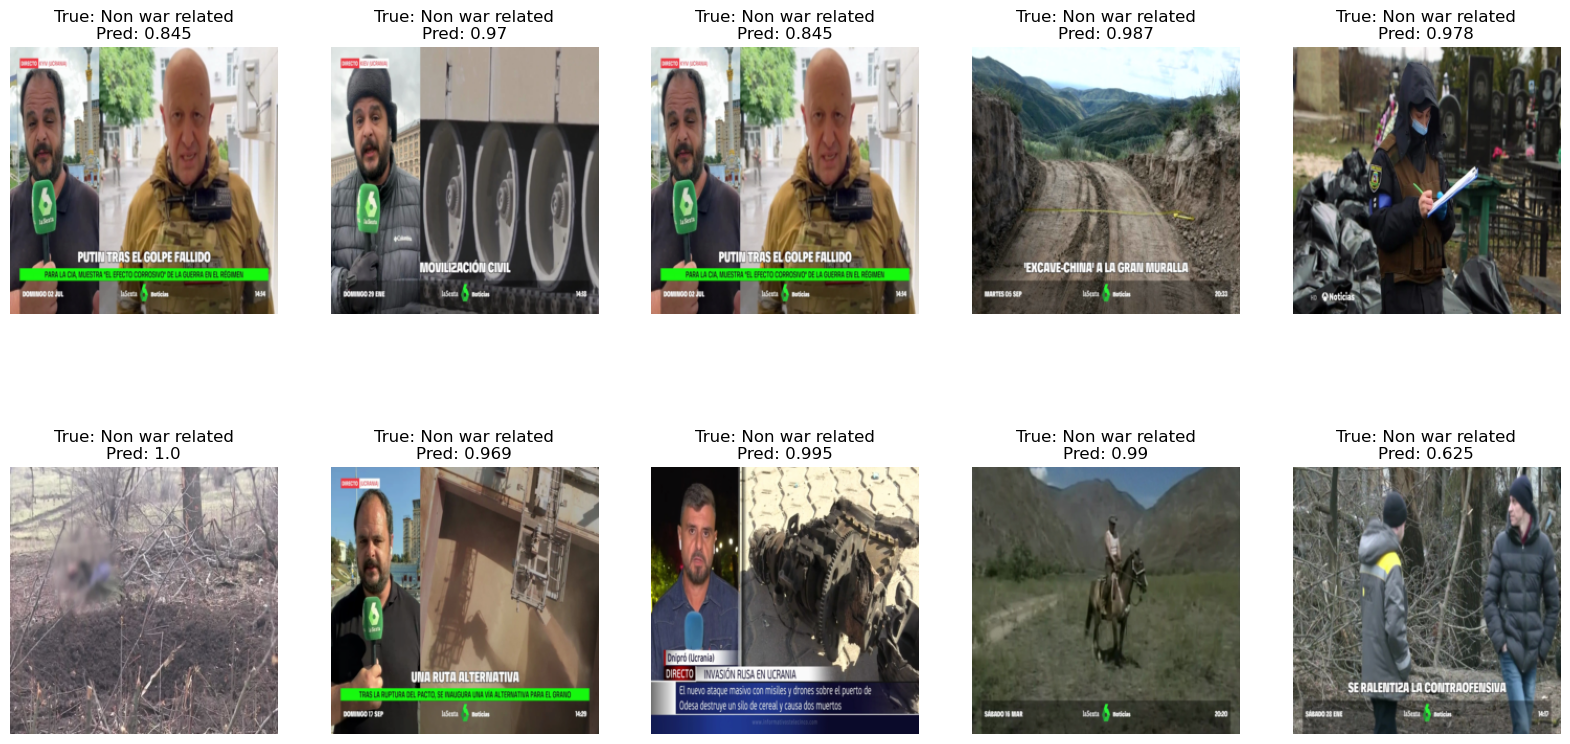

In [37]:
resnet_eval = EvaluateImages(test_images, test_labels, test_preds, test_probs)
resnet_eval.plot_false_positives(332, probs=True)

## Analysis of False Negatives

Last plotted image index: 391


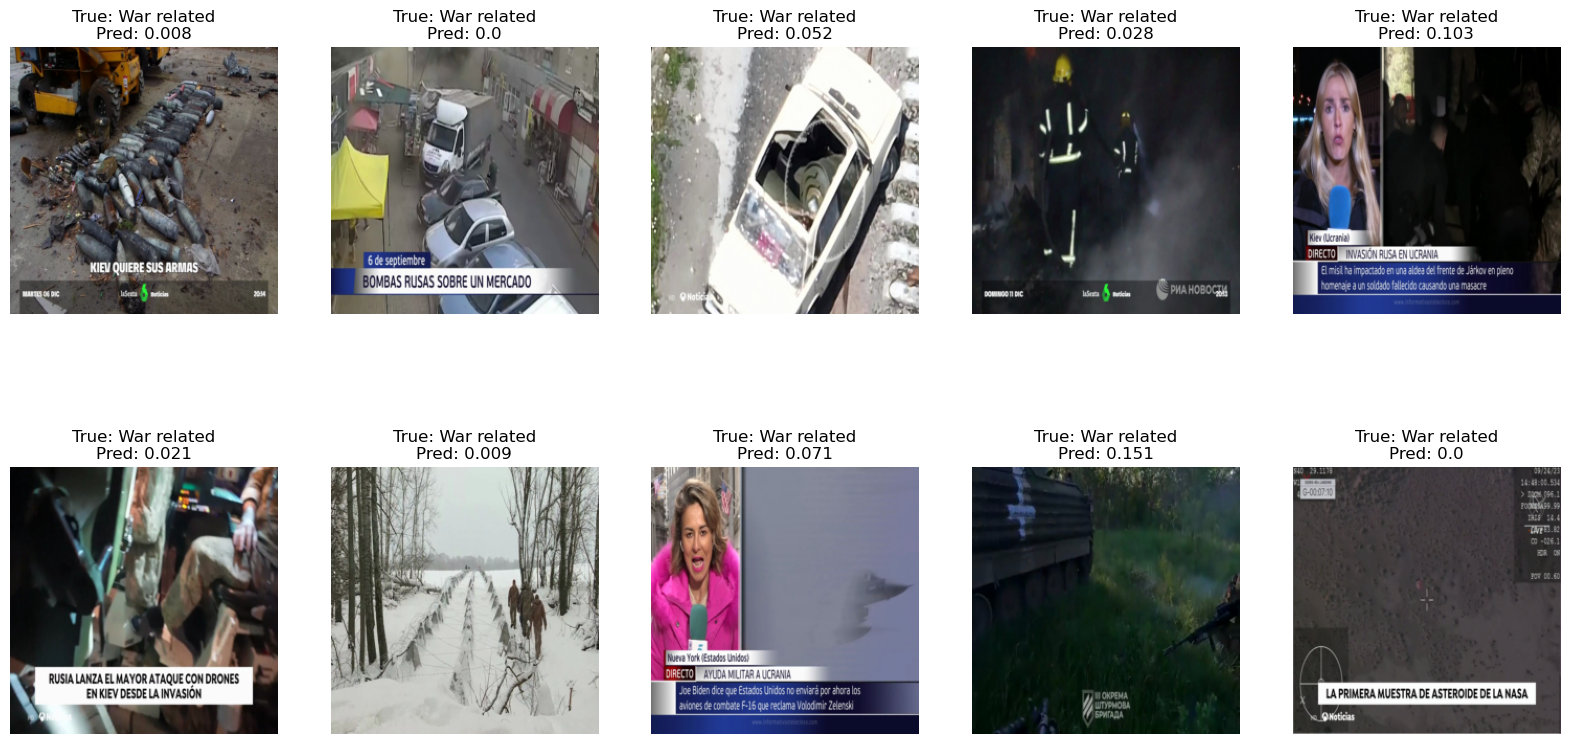

In [38]:
resnet_eval.plot_false_negatives(0, probs=True)

## Feature Importance

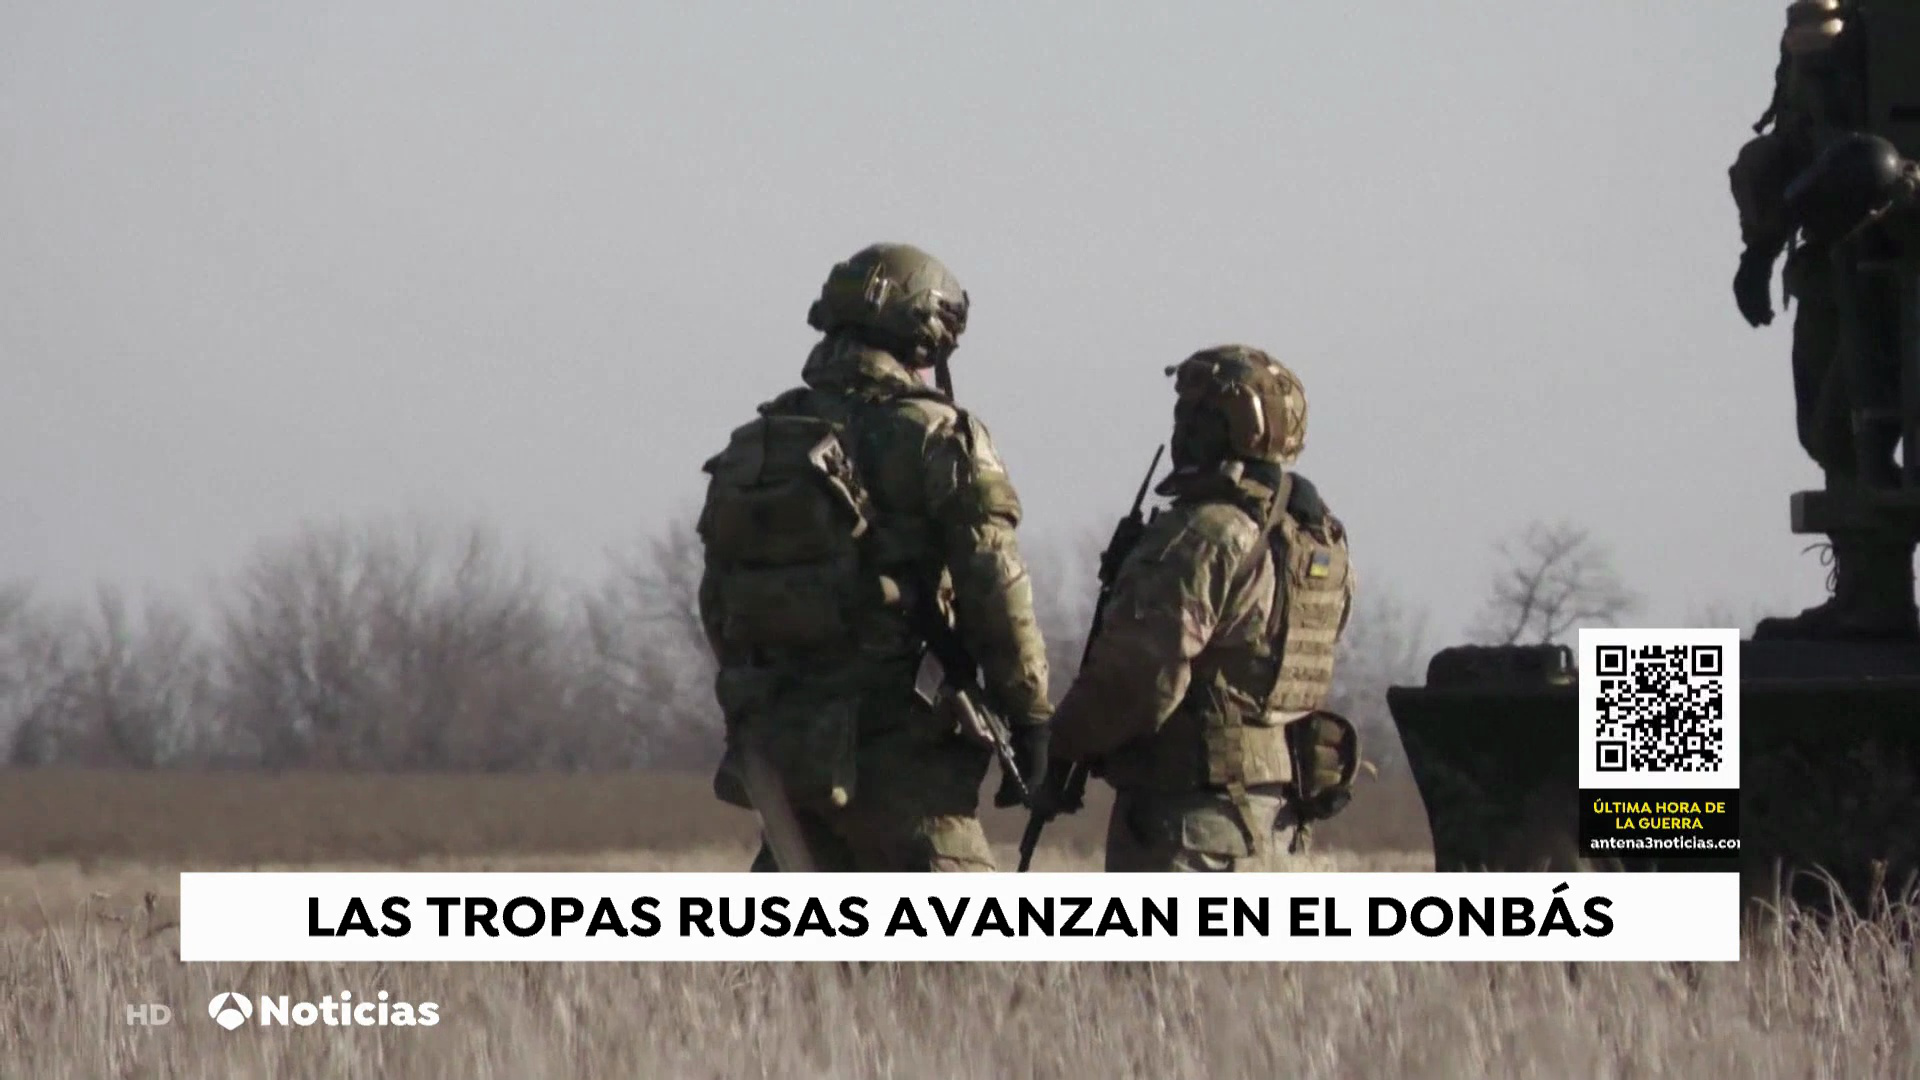

In [52]:
# Load and display the image
# image_path = '/Users/user/Desktop/backupThesis/Thesis_model/all_images/military/_80403227_025499461-1.jpg'
image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/all_frames/frame_atres_noche_2023-02-02_sec_1165.jpg'
# image_path = '/Users/user/Downloads/WhatsApp Image 2024-06-13 at 15.35.23.jpeg'
# image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/labelled_images/frame_atres_noche_2022-12-03_sec_120.jpg'
# image_path = '/Users/user/Desktop/Thesis---War-Image-Classification/data/labelled_images/frame_atres_noche_2022-12-03_sec_1181.jpg'
# image_path = '/Users/user/Desktop/backupThesis/Thesis_model/all_images/fire_images/917794892113498113_0.jpg'
image = Image.open(image_path)
image
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# plt.show()

In [53]:
# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [54]:
# Set the model to evaluation mode
trained_model.eval()

# Move the image tensor to the same device as the model
image_tensor = image_tensor.to(device)

# Get the prediction
with torch.no_grad():
    output = trained_model(image_tensor)
    probability = torch.sigmoid(output).item()

# Convert the probability to a binary prediction
prediction = 1 if probability > 0.5 else 0

# Print the prediction
labels = {0: 'Not war', 1: 'War'}
print(f"Predicted class: '{labels[prediction]}' with probability of war being: {probability:.4f}")

Predicted class: 'War' with probability of war being: 1.0000


In [110]:
# Define the same transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Plot the transformed image
transformed_image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Remove batch dimension and convert to HWC
transformed_image = transformed_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # De-normalize
transformed_image = np.clip(transformed_image, 0, 1)  # Clip to valid range

### Occlusion Sensitivity

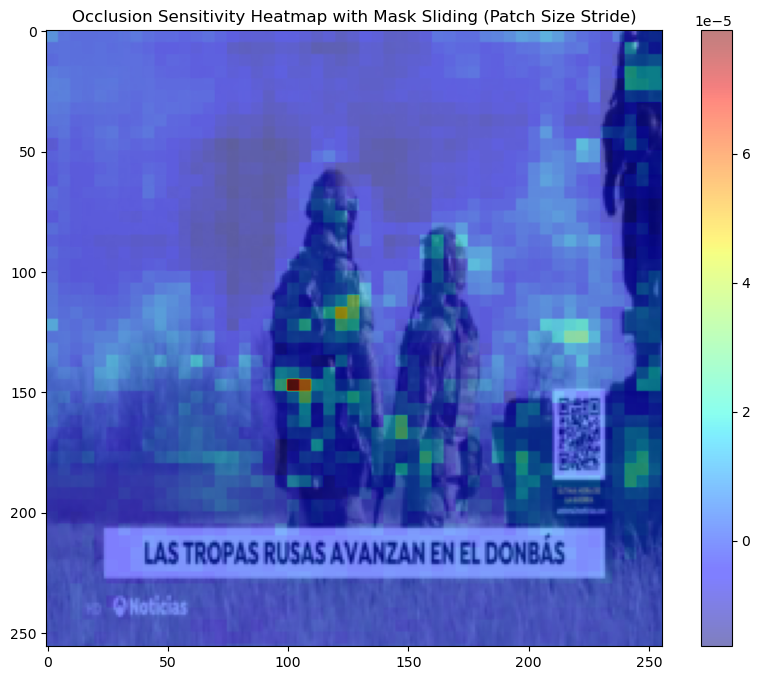

In [104]:
# Perform occlusion sensitivity analysis
trained_model.eval()
image_tensor = image_tensor.to(device)
heatmap = occlusion_sensitivity(trained_model, image_tensor, patch_size=5)

# Display the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(transformed_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap with the original image
plt.colorbar()
plt.title('Occlusion Sensitivity Heatmap with Mask Sliding (Patch Size Stride)')
plt.show()

### Occlusion Sensitivity (Reverse)

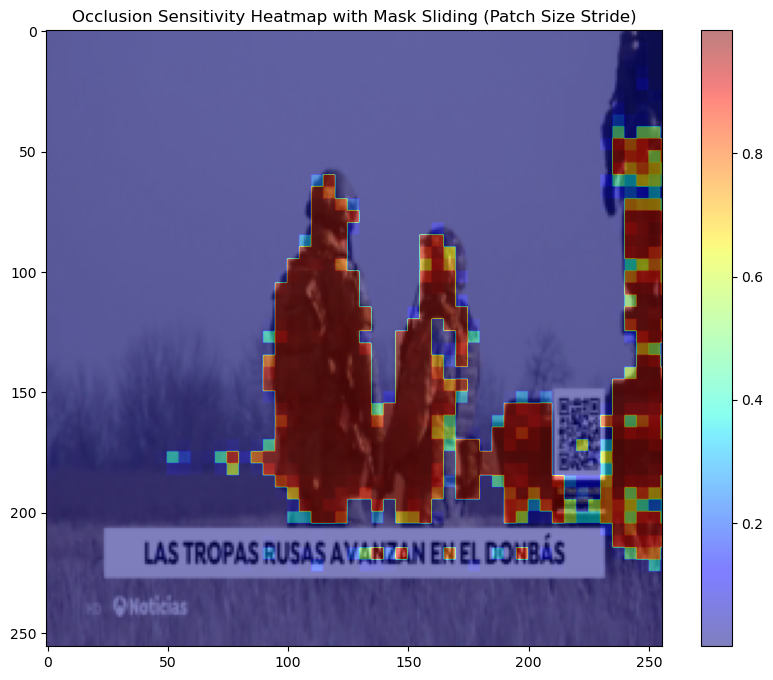

In [109]:
# Perform occlusion sensitivity analysis
trained_model.eval()
image_tensor = image_tensor.to(device)
heatmap = occlusion_sensitivity_mask(trained_model, image_tensor, patch_size=5)

# Display the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(transformed_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap with the original image
plt.colorbar()
plt.title('Occlusion Sensitivity Heatmap with Mask Sliding (Patch Size Stride)')
plt.show()